# Describing the Combined Files and Defining Research Questions
#### Jameson Carter, Mihir Bhaskar, Abhilash Biswas
#### 11/26/2021
The following code evaluates a joined file created in CombineData.ipynb. This file contains ACS tracts in Chicago and demographic information, complaints made against police officers in those locations, and geographic information about the city of chicago, within those tracts. 

In this file, we-

 - Provide some initial visualizations that describe this dataset.
 - Define some of our prediction variables, alongside some of our research questions.
 - Run a preliminary test

## Describe the Data

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 


In [48]:
data = pd.read_csv(here('./data/Combined.csv'))

### Evaluating the Target Variable- Complaints

Text(0.5, 1.0, 'Complaints in Chicago')

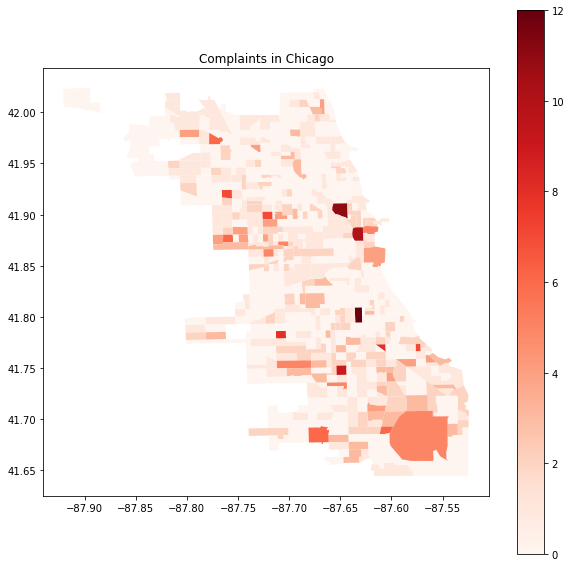

In [49]:
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
plt.rcParams['figure.figsize'] = [10, 10]
GeoData = gpd.GeoDataFrame(data, geometry='geometry')
GeoData.plot("complaint_count", cmap = "Reds", legend = True)
plt.title('Complaints in Chicago')

The above plot shows that there are a few tracts where complaints are quite high, although there is not a clear geographic relationship. There seem to be higher numbers of complaints on the South Side of the city. However, population of these tracts varies. So we create a new variable mapping complaint rate, which normalizes complaints according to tract population, and map the same plot again.

The resulting plot flags one or two tracts as having particularly high rates per their populations, masking the relationships shown in the previous plot. The top three tracts by complaint rate turned out to be:
 - Tract 8356 (1.3%), which is a small tract nestled between a large highway and a railyard on the South side, with a police station nearby.
 - Tract 4212 (0.7%), which is another small tract nestled between a railyard on the South side and a large cemetary, with a police station nearby.
 - Tract 5003 (0.4%), is yet another small tract nestled between a railyard on the South side and a highway, and again, is right by a police station. 	
 
I evaluated these tracts using the following https://www.chicagocityscape.com/maps/?place=censustract-17031835600

Text(0.5, 1.0, 'Complaints Normalized Against Population in Chicago')

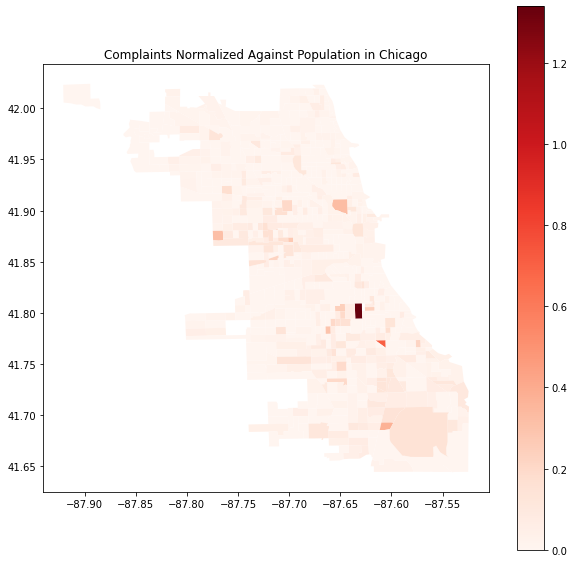

In [50]:
GeoData['complaint_rate'] = 100*GeoData['complaint_count']/GeoData['B01001_001E']
GeoData.plot("complaint_rate", cmap = "Reds", legend = True)
plt.title('Complaints Normalized Against Population in Chicago')

In [51]:
GeoData.sort_values('complaint_rate', ascending = False).head(3)

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0017E,...,geometry,GEOID10,complaint_count,police_stations,fire_stations,public_schools,parks,commercial_establishments,number_of_police_killings,complaint_rate
728,1400000US17031835600,896.0,16.5,3.5,39.8,40.2,14.4,60.2,2.08,3.17,...,"MULTIPOLYGON (((-87.63584 41.80905, -87.62892 ...",17031835600,12.0,1.0,0.0,0.0,1.0,43.0,0.0,1.339286
440,1400000US17031421200,1126.0,11.5,3.3,30.4,54.8,22.4,38.9,2.45,4.26,...,"MULTIPOLYGON (((-87.61304 41.77301, -87.60941 ...",17031421200,8.0,1.0,0.0,0.0,0.0,20.0,0.0,0.710480
495,1400000US17031500300,1598.0,18.7,11.5,22.9,46.9,18.7,16.0,2.00,2.97,...,"MULTIPOLYGON (((-87.61144 41.68572, -87.60986 ...",17031500300,6.0,1.0,0.0,1.0,1.0,25.0,0.0,0.375469


The following exploration finds that the typical tract (as defined by the median), exhibits a 0% complaint rate, because there are no complaints, while the average tract exhibits a 0.03% complaint rate. Less than 1 complaint is submitted within a given tract, on average.

In [52]:
GeoData[['complaint_rate','complaint_count']].describe()

,complaint_rate,complaint_count
count,798.000000,798.000000
mean,0.029584,0.810777
std,0.070619,1.383913
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.040219,1.000000
max,1.339286,12.000000


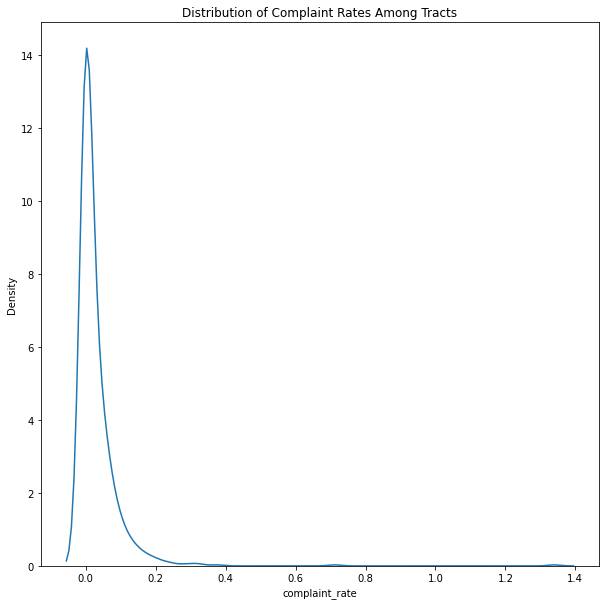

In [53]:
sns.kdeplot(GeoData['complaint_rate'])
plt.title('Distribution of Complaint Rates Among Tracts')
plt.show()

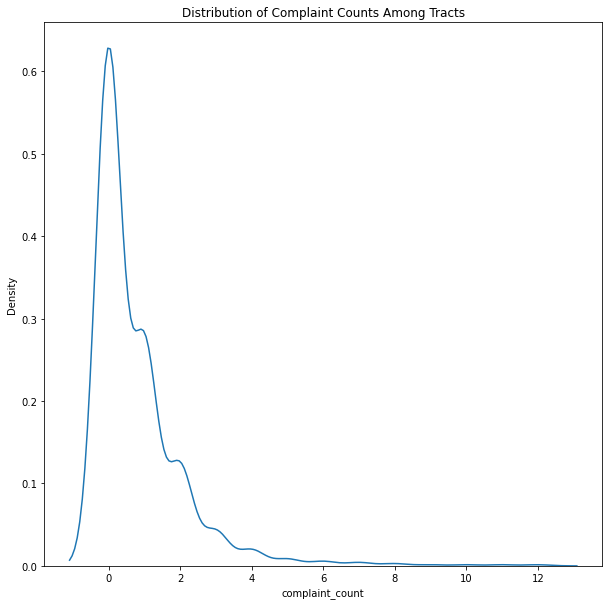

In [54]:
sns.kdeplot(GeoData['complaint_count'])
plt.title('Distribution of Complaint Counts Among Tracts')
plt.show()

### Evaluating relationships between variables

The code below creates a correlation matrix for the dataset, and filters it to those variables with the absolute value of correlation greater than 80% (since there are too many variables to visualize in a complete correlation matrix).

In [55]:
# Moving the target variables so they are at the front of the dataset
target = GeoData.pop('complaint_count')
GeoData.insert(loc=0, column='complaint_count', value=target)

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = GeoData.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)


#corr_triu.sort_values(by=['Correlation Coefficient'], inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu


Number of feature pairs that are highly correlated (i.e. >80%): 47


,,Correlation Coefficient
Col1,Col2,
DP02_0088PE,DP02_0093PE,-1.000000
DP04_0002PE,DP04_0003PE,-1.000000
DP03_0096PE,DP03_0099PE,-1.000000
B01001_001E,DP02_0069PE,0.978584
DP04_0063PE,DP04_0065PE,-0.974154
DP03_0002PE,DP03_0004PE,0.955001
DP02_0112PE,DP02_0114PE,-0.954556
DP02_0015PE,DP03_0066PE,0.940157
DP03_0119PE,DP03_0120PE,0.929261


There are several feature pairs, predominantly from the ACS data, that are highly correlated - 47 feature pairs have an absolute correlation coefficient greater than 80%. The pairs that are perfectly correlated are:
- % of population born in USA, % of population born abroad
- % of vacant housing units, % of occupied housing units
- % of households with health insurance, % of households with no health insurance

These need to be, and will be dropped, before any modelling efforts.

Some of the other pairs that are highly correlated are:
- Total Population and % of populations 18+ who are veterans (97%)
- % of occupied units heated with utility gas and % of occupied units heated with electricity (-98%)
- % of population 16 and older that is employed, and % of population 16 and older in the labour force (96%)
- % of population 5 and older that only speaks English at home, % of population that only speaks another language at home

Several of these variables will need to be dropped in the modelling effort through selection methods and cleaning.

**The code below now looks at spatial distributions of a few predictors**, to see if there are any geographic patterns

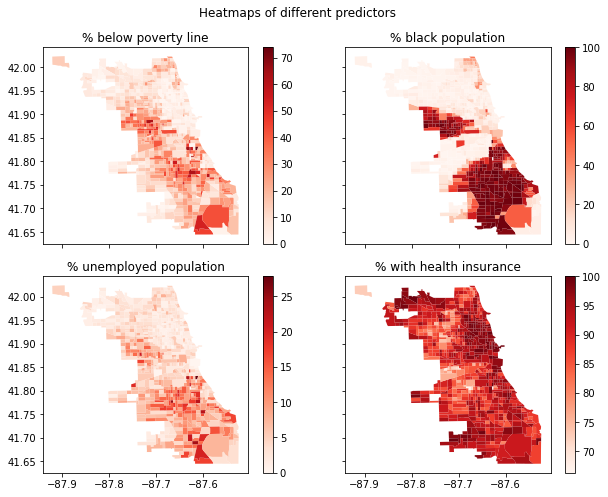

In [56]:
# Variables to create plots for in a loop
variables = ['DP03_0119PE', 'DP05_0038PE', 'DP03_0005PE', 'DP03_0096PE']
titles = ['% below poverty line', '% black population', '% unemployed population', '% with health insurance']

# Set up the subplots in a 2x2 grid and initialise the figure
fig, axes = plt.subplots(2,2, figsize=(9,7), sharex=True, sharey=True)
fig.suptitle('Heatmaps of different predictors')

# Loop through both the degree (range from 1-7), and the tile we want the plot in (from the axes)
i = -1
for var, ax in zip(variables, axes.flatten()):
    
    # Create heatmap plot
    GeoData.plot(var, cmap='Reds', legend=True, ax=ax)
    
    # Give it a title according to the titles list
    i += 1
    ax.set_title('{:s}'.format(titles[i]))

plt.tight_layout()

The plots show:
- A concentration of tracts with a high % of black families and individuals in the south side of the city
- Individuals below the poverty line, and unemployment rates follow a very similar geographic pattern, and are also starker towards the center and south sides of the city
- It is harder to discern a clear pattern in health insurance, because coverage rates are high for a much larger proportion of tracts

These plots seem to suggest that there are groupings of tracts that share similar characteristics. This informs our third research question, of wanting to explore unsupervised learning to uncover naturally occuring clusters of tracts based on their characteristics.

## Research Question 1

#### Predicting the use of force complaint rate in Chicago Census tracts

###### Why: Evaluate which tracts may have a high complaint rate and direct policy attention towards those tracts

### Preliminary prediction model - Checking the prediction accuracy and generalisibility of a linear model containing all possible predictors in the dataset (kitchen sink prediction model)




In [57]:
#Creating X and y dataframes
df_y = GeoData['complaint_rate']
df_X = GeoData.drop(columns = 'complaint_rate')
df_X = df_X.select_dtypes(['number']) 

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      
                                                                                        
#Fitting model
lm_r1 = LinearRegression()
lm_r1.fit(X_train, y_train)

#Calculating MSE
MSE_train  = mean_squared_error(y_train, lm_r1.predict(X_train))
print("Training R-squared: ", lm_r1.score(X_train, y_train))
print("MSE train: " , MSE_train)

MSE_test  = mean_squared_error(y_test, lm_r1.predict(X_test))
print("Testing R-squared: ", lm_r1.score(X_test, y_test))
print("MSE test: " , MSE_test)



Training R-squared:  0.7925109009871663
MSE train:  0.00048149661341228536
Testing R-squared:  0.5286622466316063
MSE test:  0.007319117574880578


Commentary: We have a likely overfitted model, but it's useful to see how well the model is fitting from this kitchen sink linear regression. 

The training R squared is ~80%, however the testing R squared drops quite low to 53%. This is a signal of overfitting. 
By and large, for this exploratory exercise, the key takeaway is that in the training set atleast, the predictors are able to explain 80% of the variation in complaint rate. 

## Research Question 2

### Classifying the use of force complaint rate in Chicago census tracts

##### Why: As compared to a prediction model, evaluate whether we can better predict whether a tract would have any use of force complaints or not as compared to predicting the exact complaint rate. This would still have the same implication of directing policy attention towards tracts where we expect some use of force complaints to happen

### Preliminary classification model - Checking whether a kitchen sink classification model performs better than a prediction model. 

We will classify complaint rate into Any complaints (1) and no complaints (0)

In [58]:
#Creating the first classification
GeoData['any_complaints'] = np.where(GeoData['complaint_rate']>0, 1, 0)


              precision    recall  f1-score   support

           0      0.726     0.711     0.719        97
           1      0.569     0.587     0.578        63

    accuracy                          0.662       160
   macro avg      0.648     0.649     0.648       160
weighted avg      0.664     0.662     0.663       160



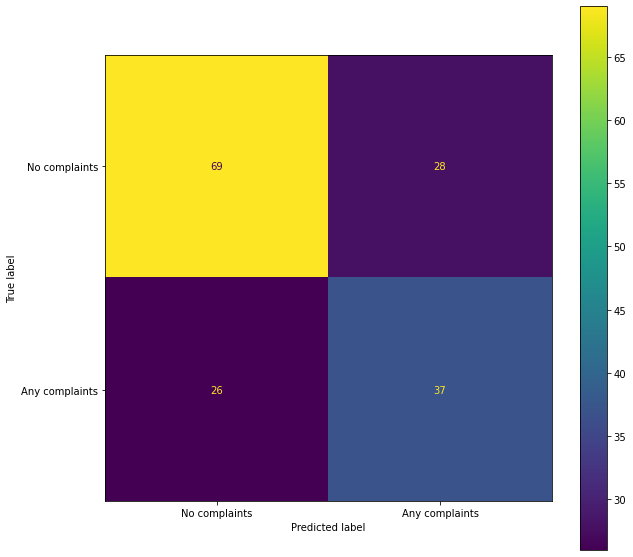

In [59]:
#Creating the classification model (1)

#Creating X and y dataframes
df_y = GeoData['any_complaints']
df_X = GeoData.drop(columns = ['complaint_rate','any_complaints'])
df_X = df_X.select_dtypes(['number']) 



#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      

#Importing class
from sklearn.naive_bayes import GaussianNB

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

                                                                                        


Commentary: We see that a Naive Bayesian classification model has quite low accuracy in predicting whether a tract has any complaints or not. This is an initial indication that our model may be affected by irrelevant variables and hence we should apply subsetting methods to keep only a subset of the full predictor list. 

## Research Question 3

### a) Can we effectively cluster census tracts into groups having similar characteristics (unsupervised learning)
### b) Do census tracts in a given cluster have similar outcomes in terms of use of force complaints

#### This analysis would allow us to evaluate whether tracts that have similar outcomes (from b) also have similar characteristics. 

##### NOTE: We will explore and analyse this research question as a part of our final submission

## Preliminary Testing

## Sources

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 